In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# update import path
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..', 'src'))

import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from importlib import reload
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

# no warnings on dataframe slices
pd.options.mode.chained_assignment = None

In [2]:
# read csv
data = pd.read_csv(os.path.join('..', 'data', 'datasets', 'history_20181108_1235.csv'), index_col=0)

# make datetime index (could also be done directly in read_csv)
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')

print (data.shape)
data.head()

(16219, 9)


,angle_of_attack,boat_angle,boat_heel,boat_speed,course_error,rudder_angle,target_angle,wind_direction,wind_speed
datetime,,,,,,,,,
2018-11-08 12:21:22.510491,-9.448479,359.940099,2.995053,4.892557,-129.563202,0.0,129.503301,350.491620,18.130755
2018-11-08 12:21:22.568455,-8.985402,359.884727,2.768579,4.787800,-129.618574,0.0,129.503301,350.899326,17.618856
2018-11-08 12:21:22.620147,-8.428340,359.831195,2.676610,4.682911,-129.672106,0.0,129.503301,351.402855,18.146943
2018-11-08 12:21:22.671629,-8.609446,359.773863,2.866618,4.583329,-129.729438,-0.3,129.503301,351.164417,19.023579
2018-11-08 12:21:22.722509,-8.775135,359.744002,2.868061,4.486235,-129.759300,-0.6,129.503301,350.968866,18.678803


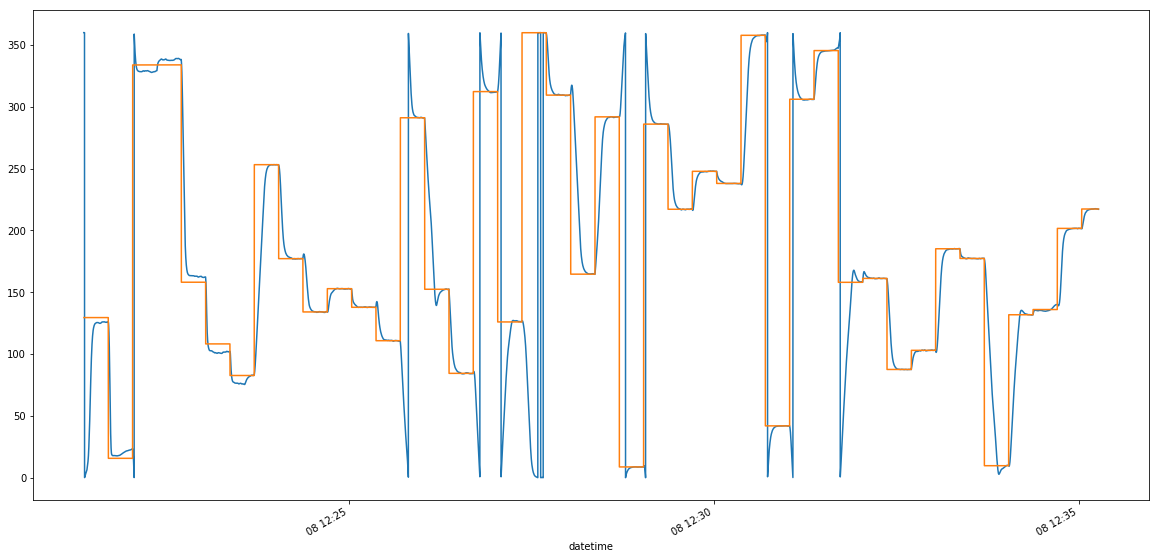

In [3]:
# show the boat approaching the target course
_, ax = plt.subplots(figsize=(20, 10))
data['boat_angle'].plot(ax=ax)
data['target_angle'].plot(ax=ax)

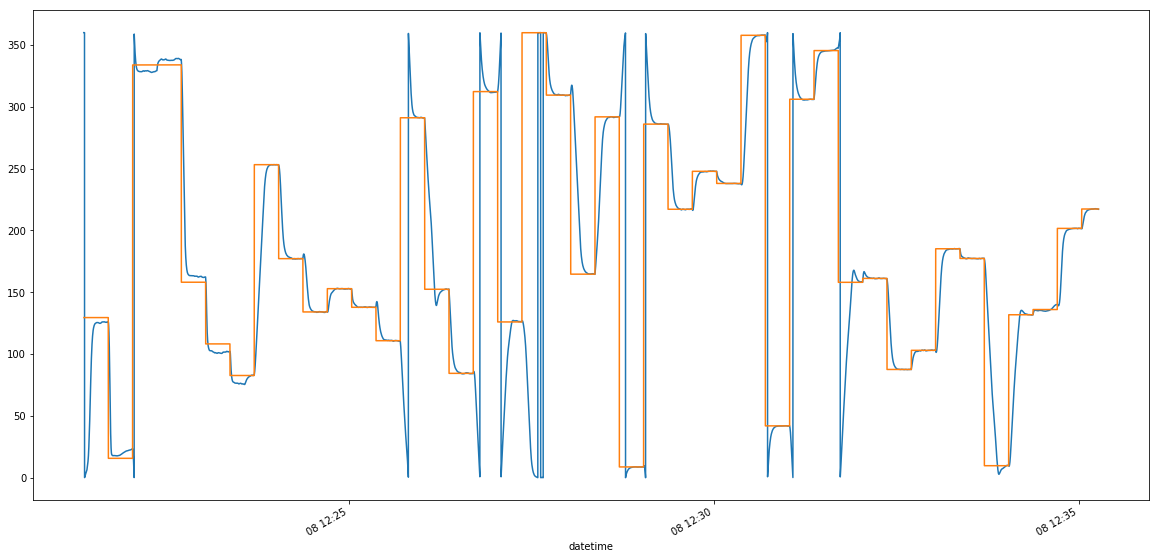

In [4]:
# remove data points with significant course error
data1 = data[data['course_error'].abs() < 2].reset_index()

# show again
_, ax = plt.subplots(figsize=(20, 10))
data['boat_angle'].plot(ax=ax)
data['target_angle'].plot(ax=ax)

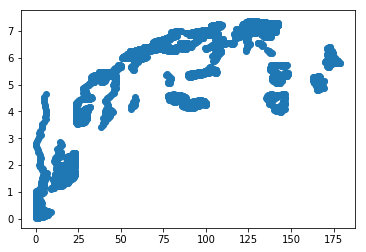

In [5]:
# scatter plot to show general shape of polar
data1['aoa_abs'] = data1['angle_of_attack'].abs()
plt.scatter(data1['aoa_abs'], data1['boat_speed'])

# start training

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

# select features and target
y = data1['boat_speed']
x = data1[['aoa_abs', 'wind_speed']]

# split test/train sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)

# train model
#model = LinearRegression()
model = GradientBoostingRegressor(n_estimators=100)
#model = make_pipeline(PolynomialFeatures(4), Ridge())

model.fit(x_train, y_train)

# show performance
pred_y = model.predict(x_test)
print ('MAE: ', mean_absolute_error(pred_y, y_test))

MAE:  0.15023042872459336


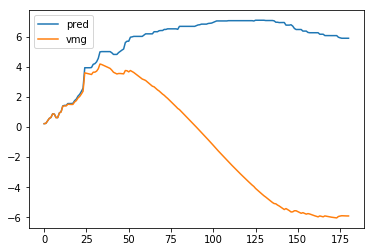

In [40]:
# function to predict boat speeds for all angles
def predict_boat_speeds(model, wind_speed):
    aoa = np.linspace(0, 180, 181)
    df = pd.DataFrame()
    df['aoa'] = aoa
    df['wind_speed'] = wind_speed
    df['pred'] = model.predict(df[['aoa', 'wind_speed']])
    df['vmg'] = df['pred'] * np.cos(np.radians((df['aoa'])))
    return df

# predict for 20 knots
df = predict_boat_speeds(model, 20)

# show predicted speed and vmg
plt.plot(df['aoa'], df['pred'])
plt.plot(df['aoa'], df['vmg'])
plt.legend()

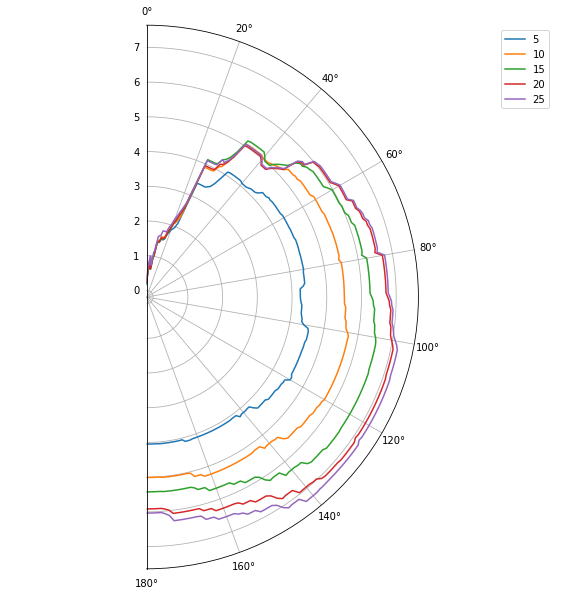

In [41]:
# show polar plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, polar=True)

for wind_speed in [5, 10, 15, 20, 25]:
    df = predict_boat_speeds(model, wind_speed)
    _ = ax.plot(np.radians(df['aoa']), df['pred'], label=wind_speed)

ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
plt.legend()
plt.show()

In [42]:
# predict tack and gybe angles for all wind speeds
data = pd.DataFrame()
for wind_speed in range(2, 50):
    df = predict_boat_speeds(model, wind_speed)
    row = {
        'wind_speed': wind_speed,
        'tack_angle': df['vmg'].idxmax(),
        'gybe_anble': df['vmg'].idxmin(),
    }
    data = data.append([row])

# wind speed as index
data = data.set_index('wind_speed')

# save to file
data.to_pickle(os.path.join('..', 'data', 'angles.pkl'))

# show first rows
data

,gybe_anble,tack_angle
wind_speed,,
2,180,33
3,180,33
4,180,33
5,180,33
6,180,33
7,180,33
8,180,33
9,180,33
10,180,33
